# Finding spectral limits of features

In [1]:
import rasterio
import satsearch
import xarray as xr
import os
from data_tools import *

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [3]:
# Read in reflectance data
import numpy as np
img = np.load("/srv/shared/planetpieces/795543_1060719_2017-09-28_1021_BGRN_Analytic_refl.npy")
img.shape

In [4]:
def reshape_vrts(img_stack):
    '''Function to reshape vrt image stack for classification'''
    for layer in range(0, img_stack.shape[0]):
        arr=img_stack[layer, :, :]
        if layer == 0:
            reshaped = arr
        else:
            reshaped = np.dstack((reshaped, arr))
    return reshaped

In [93]:
z = reshape_vrts(img)

In [9]:
# subset data
subset = z[4000:,0:4000,:]

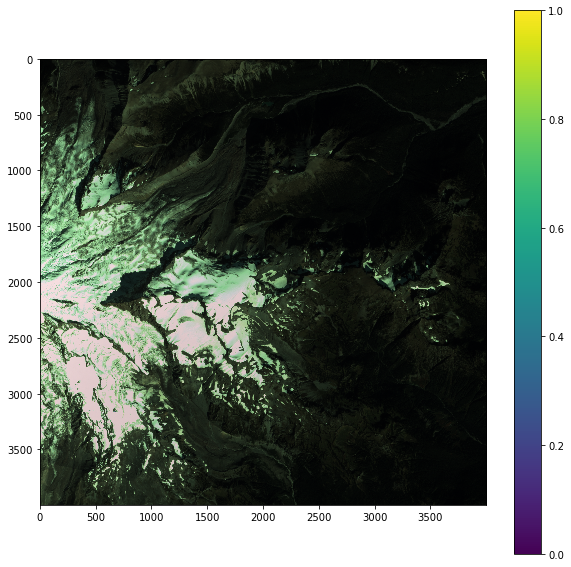

In [115]:
# Normalize bands into 0.0 - 1.0 scale
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize band DN
nirn = normalize(subset[:,:,3]); redn = normalize(subset[:,:,2])
greenn = normalize(subset[:,:,1]); bluen = normalize(subset[:,:,0])

# Stack bands
nrg = np.dstack((redn, greenn, bluen))

# View the color composite
plt.figure(figsize=(10,10))
plt.imshow(nrg)
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


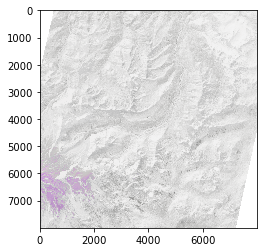

In [117]:
rasterio.plot.show(img)

In [10]:
def plot_spec(arr, cmap='Greys_r', arr_title='Plot title',
            width=16, height=12, sv=None,
            mask_low=None, mask_high=None, vmin=None, vmax=None):
    '''
    Function that quickly plots input array and linearly maps data values to specified limits
    '''
    
    fig, ax = plt.subplots(1, figsize=(width, height))
    if mask_low is not None:
        arr = np.ma.masked_outside(arr, mask_low, mask_high)
    if vmin is not None:
        vmin=vmin
        vmax=vmax
        thisPlot = ax.imshow(arr, cmap=cmap, vmin=vmin, vmax=vmax)
    else:
        thisPlot = ax.imshow(arr, cmap=cmap)
    fig.colorbar(thisPlot, ax=ax)
    plt.title(arr_title);
    if sv is not None:
        figName='plot_' + sv + '.png'
        print(figName)
        plt.savefig(figName)

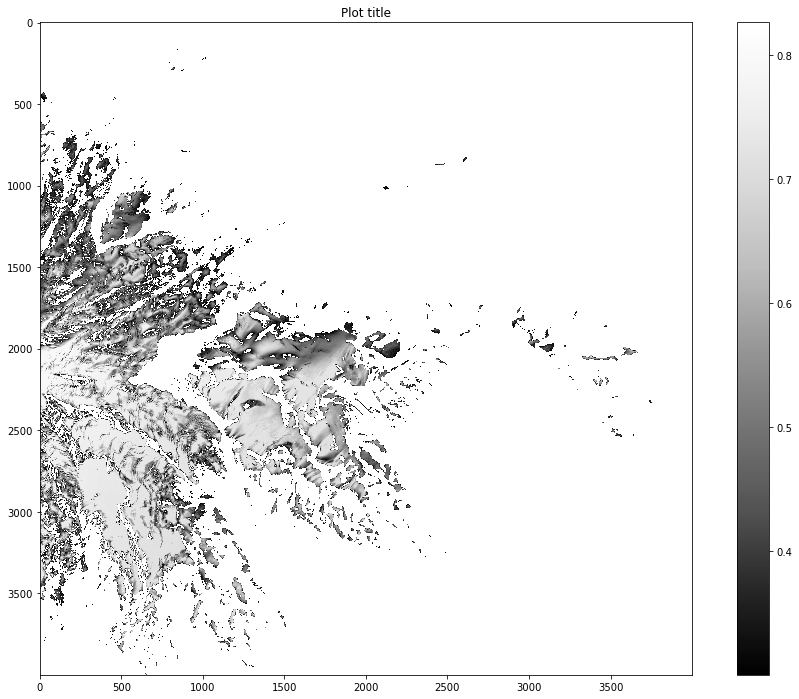

In [11]:
# quick basic mask of given band
plot_spec(z[4000:,0:4000,2], mask_low=0.3,mask_high=1)

In [91]:
from rasterio.plot import show

def plot_sub(ar, arr_title='Rock reflectance threshholds',
            masks=0):
    '''plots each band masked by selected range of values for a given feature'''
    # cols 
    cmaps=['Blues',"Greens","Reds","Reds"]

    # new style method 1; unpack the axes
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0,hspace=0)
    # masking
    ar0 = np.ma.masked_outside(ar[:,:,0], masks[list(masks.keys())[0]][0],masks[list(masks.keys())[0]][1])
    ar1 = np.ma.masked_outside(ar[:,:,1], masks[list(masks.keys())[1]][0],masks[list(masks.keys())[1]][1])
    ar2 = np.ma.masked_outside(ar[:,:,2], masks[list(masks.keys())[2]][0],masks[list(masks.keys())[2]][1])
    ar3 = np.ma.masked_outside(ar[:,:,3], masks[list(masks.keys())[3]][0],masks[list(masks.keys())[3]][1])

    #ax1.plot(ar0, cmap=cmaps[c])
    show(ar0, cmap=cmaps[0], ax=ax1); show(ar1, cmap=cmaps[1], ax=ax2)
    show(ar2, cmap=cmaps[2], ax=ax3); show(ar3, cmap=cmaps[3], ax=ax4)
    
    # titles
    ax1.set_title(list(masks.keys())[0]); ax2.set_title(list(masks.keys())[1])
    ax3.set_title(list(masks.keys())[2]); ax4.set_title(list(masks.keys())[3])
    fig.suptitle(arr_title, fontsize=16)
    
    text(500, 3500,'matplotlib', ha='center', va='center', transform=ax.transAxes)



In [ ]:
def spec_class(arr, classf):
    '''function to classify an image based on a range of wavelengths in each band'''
    if len(classf)!=arr.shape[2]:
        print("!!!Not all band ranges defined")
        exit()
    for c in range(0,len(classf)):
        if c==0: ar0 = arr[:,:,c]
        ar0 = np.ma.masked_outside(ar0, classf[list(classf.keys())[c]][0],classf[list(classf.keys())[c]][1])
    return(ar0)

In [ ]:
# reflectance values
snow_class = {'blue': (0.4,1),'green': (0.4,1),'red': (0.4,1),'nir': (0.2,0.8)}

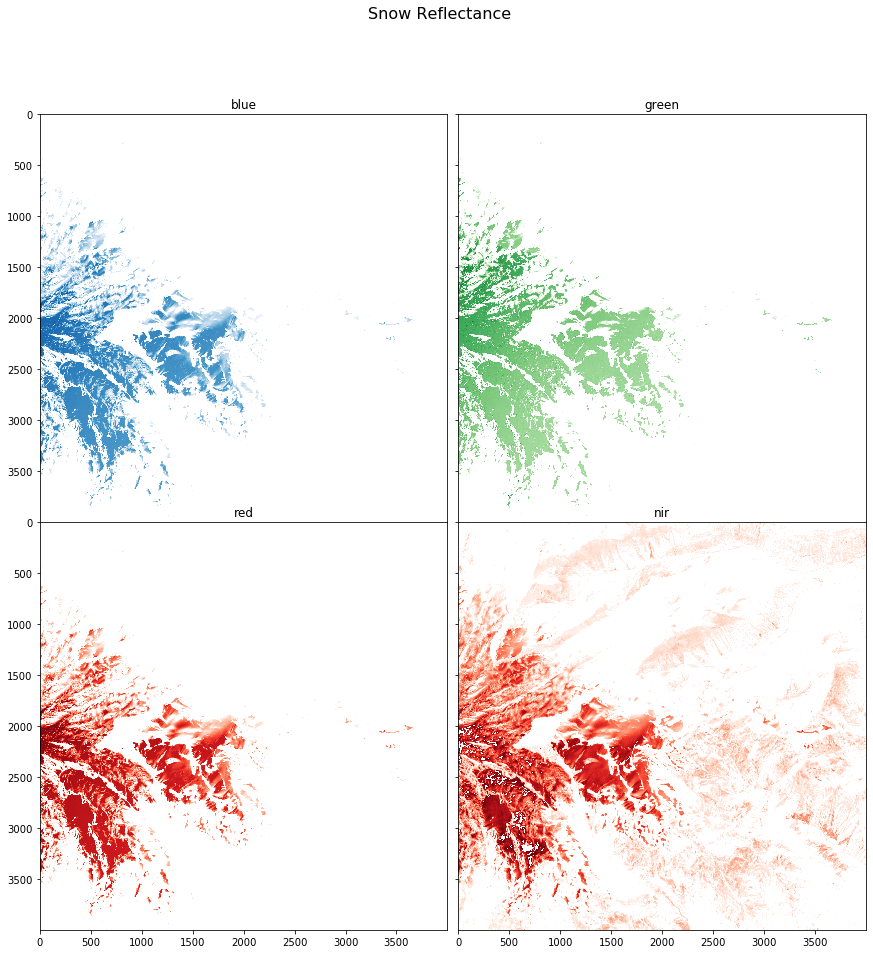

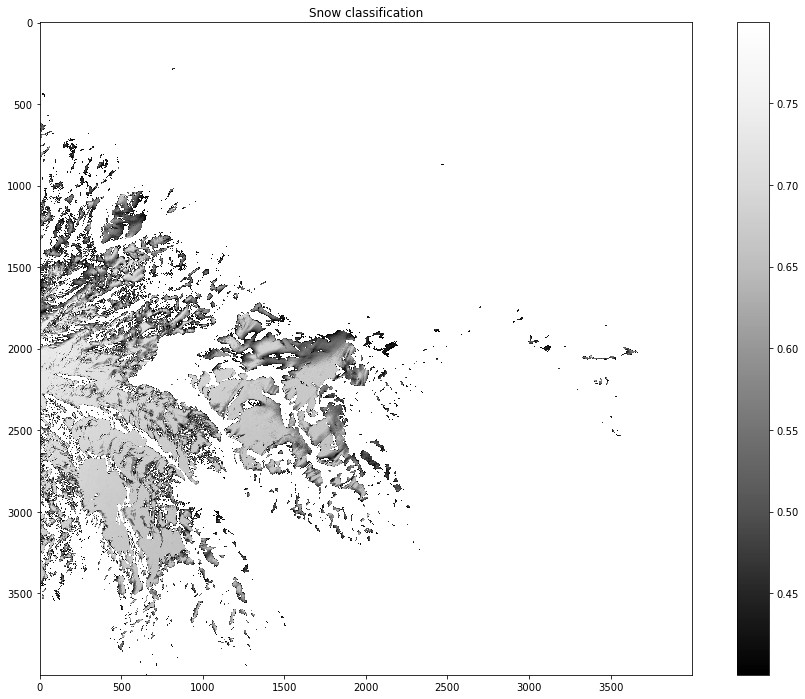

In [108]:
# Snow threshold
snow_class = {'blue': (0.6,1),'green': (0.5,1),'red': (0.4,1),'nir': (0.4,0.8)}
snow_class = {'blue': (0.4,1),'green': (0.4,1),'red': (0.4,1),'nir': (0.2,0.8)} # good
plot_sub(subset,masks=snow_class, arr_title="Snow Reflectance")

# create classification
snowimg = spec_class(subset, snow_class)
plot_me(snowimg,arr_title="Snow classification")

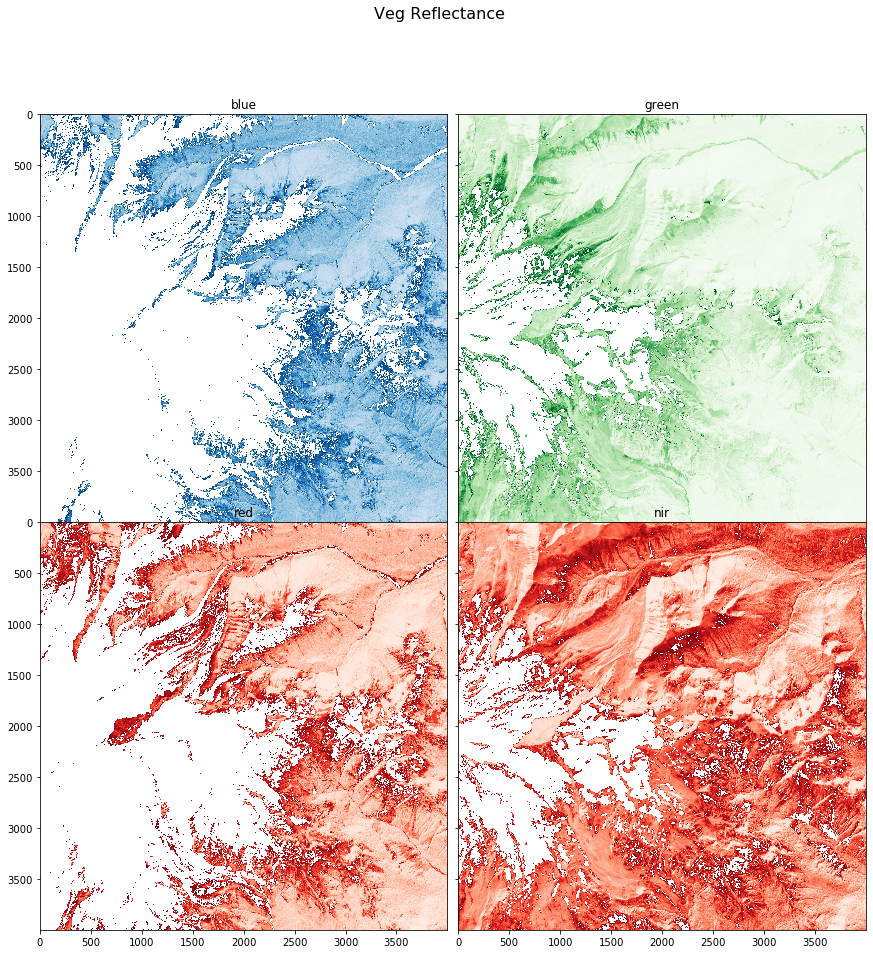

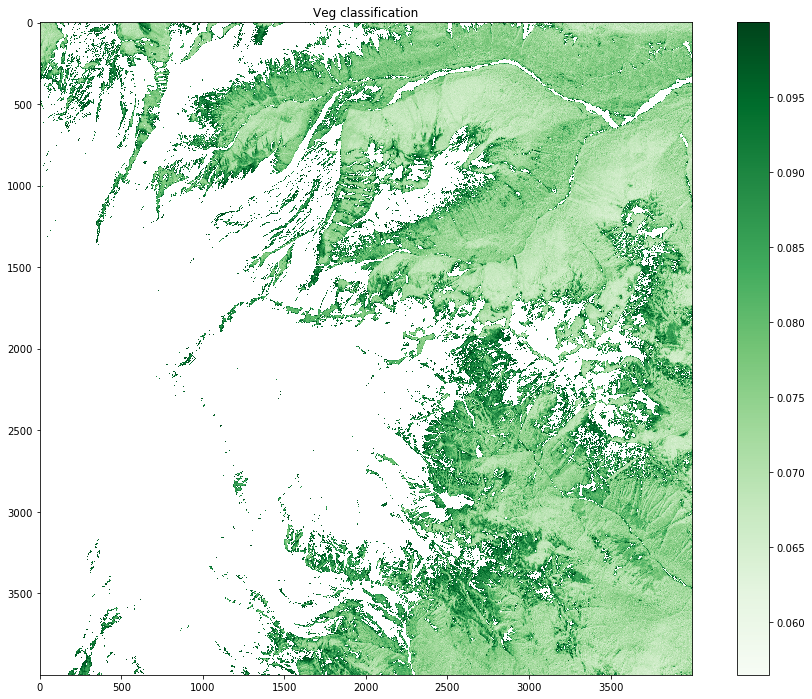

In [109]:
## Wavelengths
# blue (0.455-0.515)
# Green (0.5-0.59)
# Red (0.59-0.67)
# NIR (0.78-0.86)

# Veg threshold
veg_class = {'blue': (0,0.1),'green': (0,0.3),'red': (0,0.1),'nir': (0,0.3)} # good
plot_sub(subset,masks=veg_class, arr_title="Veg Reflectance")

# create classification
vegimg = spec_class(subset, veg_class)
plot_me(vegimg,arr_title="Veg classification",cmap="Greens")

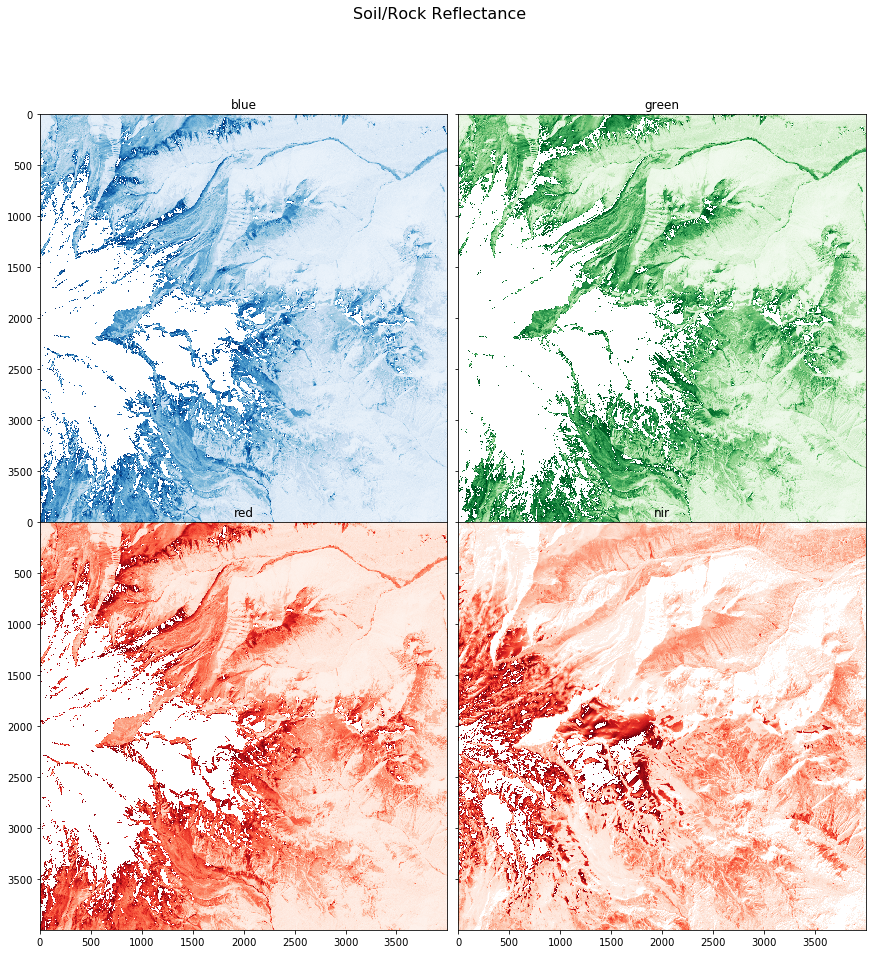

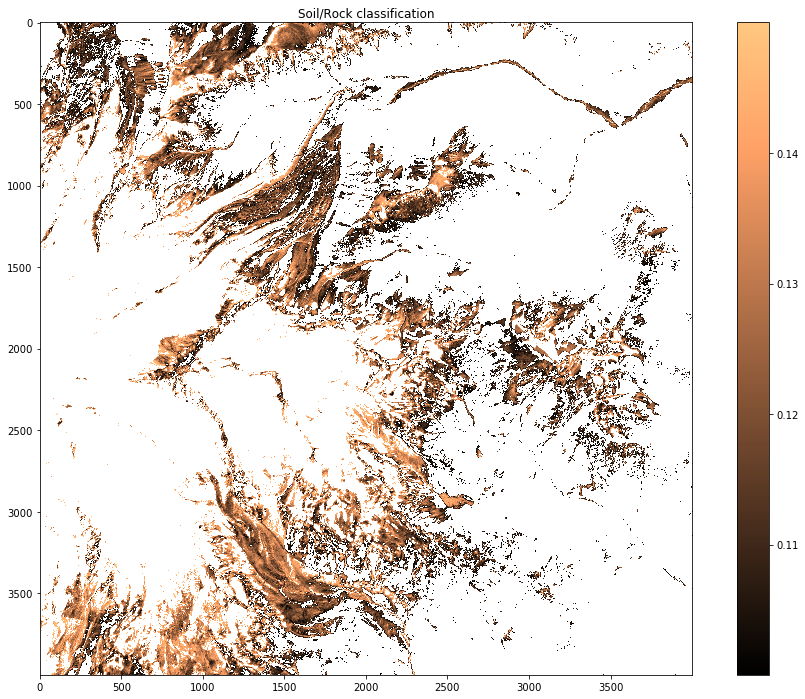

In [112]:
# Soil/Rock threshold
rock_class = {'blue': (0,0.2),'green': (0,0.15),'red': (0,0.2),'nir': (0.1,0.6)} #good
# rock_class = {'blue': (0,0.2),'green': (0,0.15),'red': (0.1,0.2),'nir': (0.1,0.4)}
plot_sub(subset,masks=rock_class, arr_title="Soil/Rock Reflectance")

# create classification
rockimg = spec_class(subset, rock_class)
plot_me(rockimg,arr_title="Soil/Rock classification",cmap="copper")

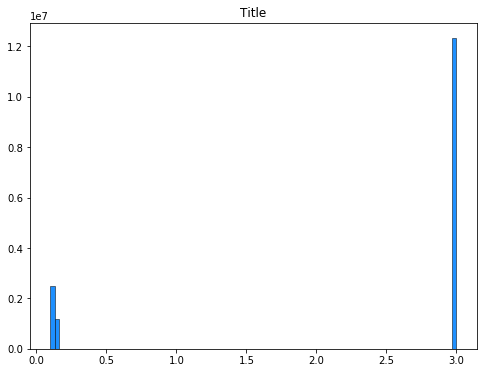

In [155]:
histo_me(rockfill)

In [128]:
# Stack bands
class_img = np.dstack((snowfill, vegfill, rockfill))

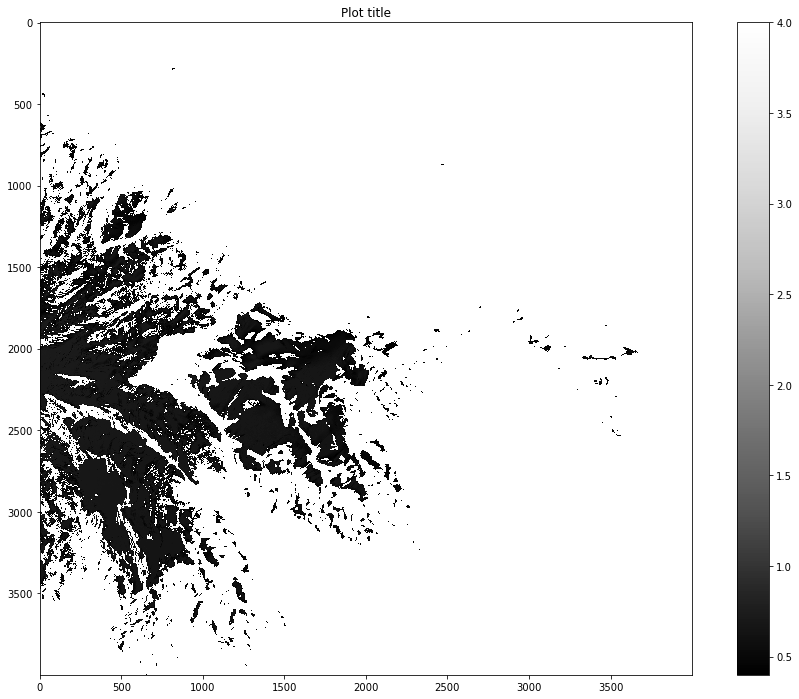

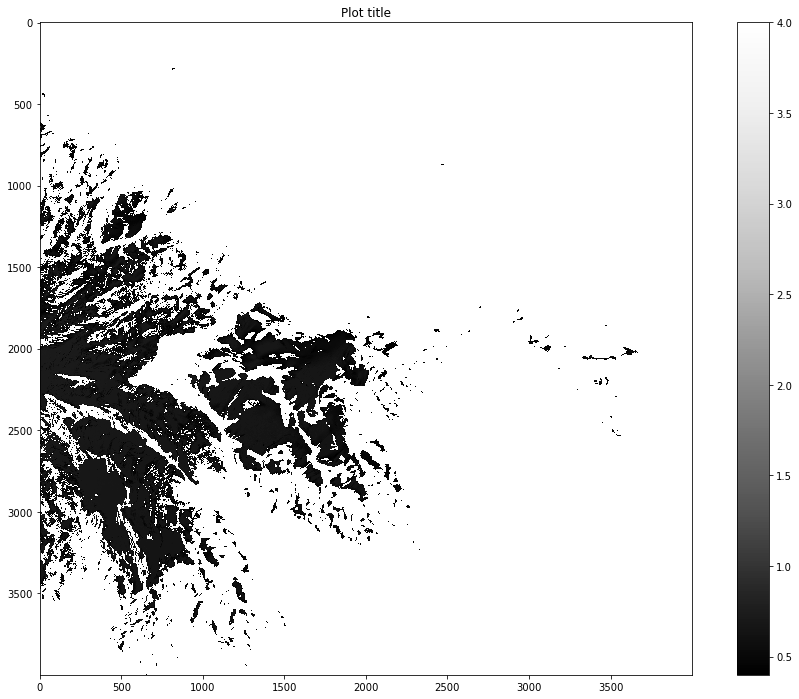

In [145]:
snowfill = np.ma.filled(snowimg, fill_value=4)
plot_me(snowfill)
class_img = snowfill
class_img = np.where(class_img==1.0, -9999, class_img)
plot_me(class_img)

In [152]:
# fill masked values
    snowfill = np.ma.filled(snow, fill_value=3)
    vegfill = np.ma.filled(veg, fill_value=3)
    rockfill = np.ma.filled(rock, fill_value=3)

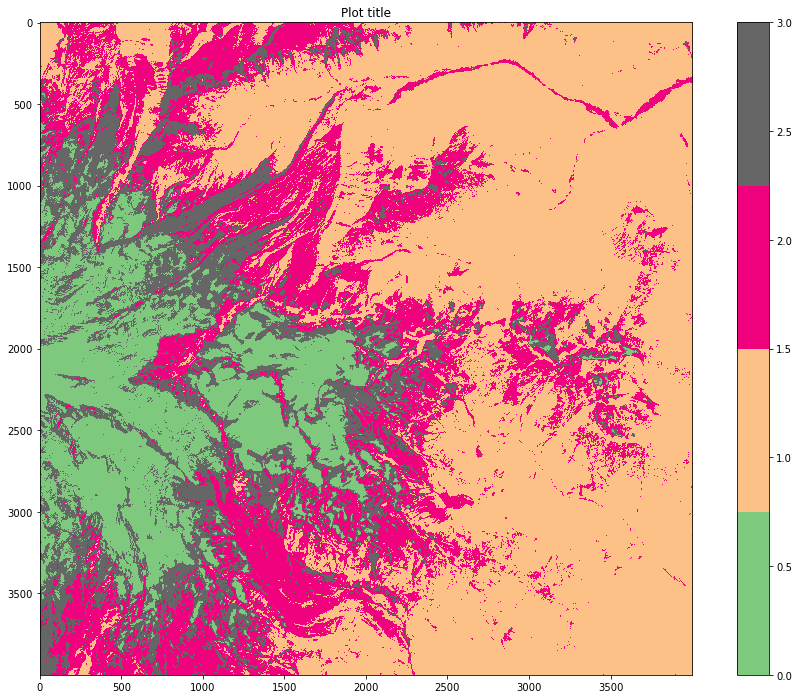

In [156]:
from matplotlib import cm

class_img = snowfill
class_img = np.where(class_img<1.0, 0, class_img)
vv = np.where(vegfill<1.0, 1, vegfill); class_img[vv==1] = vv[vv==1]
rr = np.where(rockfill<1.0, 2, rockfill); class_img[rr==2] = rr[rr==2]
#class_img[snowfill==1.0] = rr[rr==1.0]

cols = cm.get_cmap('Accent', 4)
plot_me(class_img,cmap=cols)
#  
# plot_me(sn)

In [13]:
## Wavelengths
# blue (0.455-0.515)
# Green (0.5-0.59)
# Red (0.59-0.67)
# NIR (0.78-0.86)

## Reflectance
# Snow/ice      - b:>0.4 g:>0.3 r:0.4-1 n:0.2
# vegetation - b:<0.3 g:>0.15 r:0.2-0.4 n: >0.4
# rock/soil  - b:<0.3 g:<0.15 r:0.2-0.4 n: <0.4

In [118]:
# NDVI (0.1 and below) correspond to barren areas of rock, sand, or snow. 
# Moderate values represent shrub and grassland (0.2 to 0.3), 
# while high values indicate temperate and tropical rainforests (0.6 to 0.8).
ndvi = (nirs-reds)/(nirs+reds)
# NDSI better with SWir (1.55 - 1.75)
ndsi2 = (greens - nirs)/(greens + nirs)

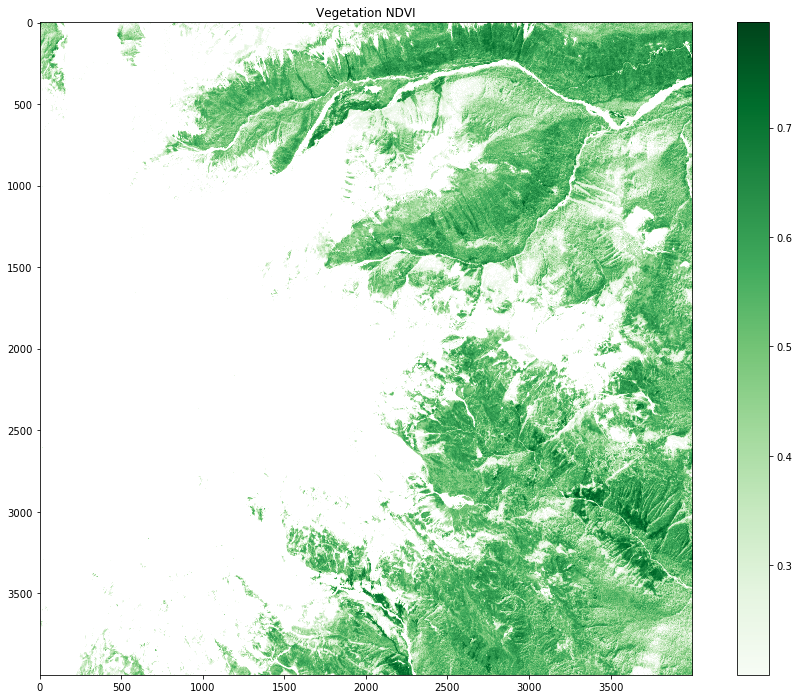

In [119]:
plot_spec(ndvi,arr_title="Vegetation NDVI", mask_high=0.8, mask_low=0.2,cmap='Greens')

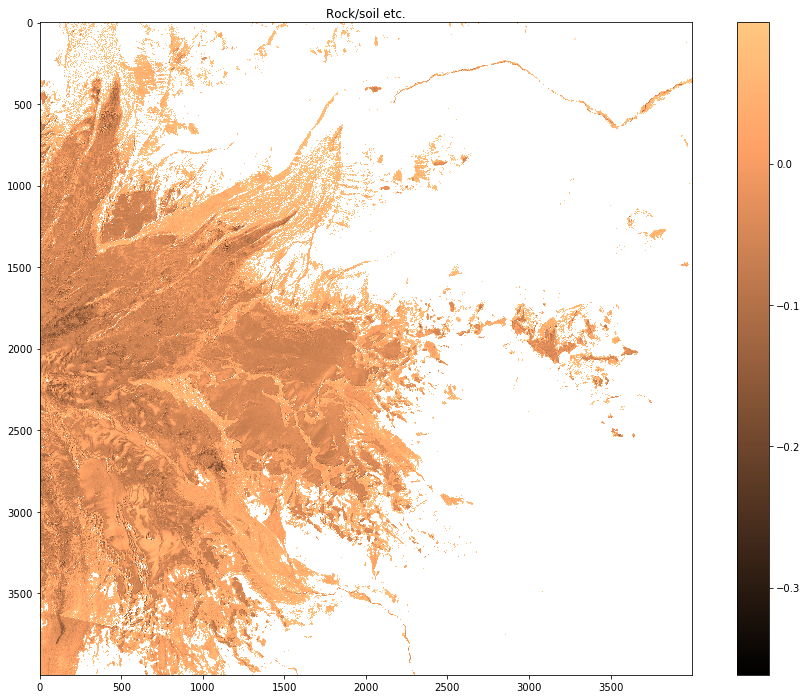

In [120]:
plot_spec(ndvi,arr_title="Rock/soil etc.", mask_high=0.1, mask_low=-1,cmap='copper')

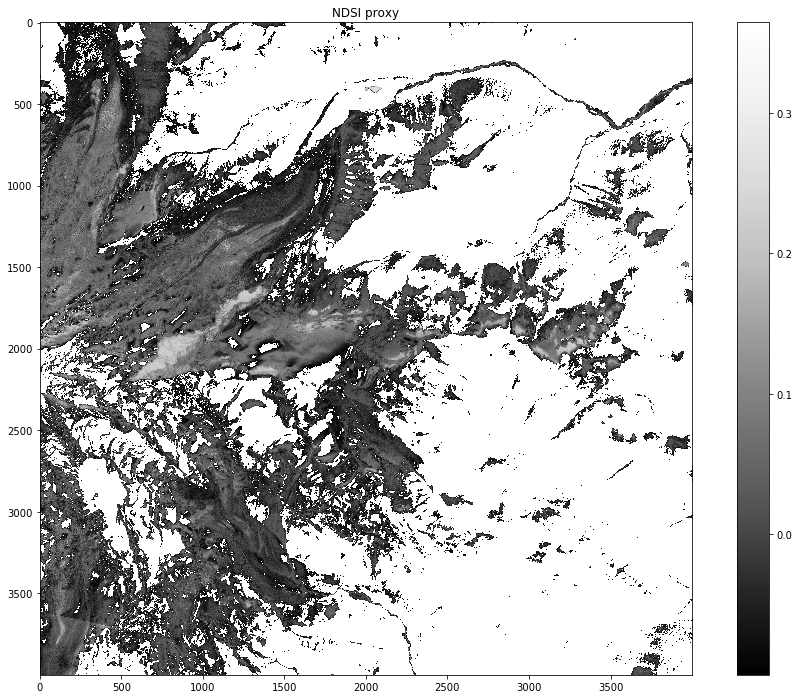

In [41]:
plot_spec(ndsi2,arr_title="NDSI proxy", mask_high=1,mask_low=-0.1)

In [48]:
## Reflectance
# Snow/ice      - b:>0.4 g:>0.3 r:0.4-1 n:0.2
# vegetation - b:<0.3 g:>0.15 r:0.2-0.4 n: >0.4-1
# rock/soil  - b:<0.3 g:<0.15 r:0.2-0.4 n: <0.4
snow_class = {'blue': (0.4,1),'green': (0.4,1),'red': (0.4,1),'nir': (0.2,0.8)}
veg_class = {'blue': (0,0.3),'green': (0.15,1),'red': (0.2,0.4),'nir': (0.4,0.8)}
rock_class = {'blue': (0,0.3),'green': (0,0.15),'red': (0.2,0.4),'nir': (0,0.4)}